<a href="https://colab.research.google.com/github/sumaiya008/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/blob/main/notebooks/1_0_mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install mrcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54907 sha256=9d23237d9380259b2a4316a80cc01bc29e0266d9d092db663b8ba01cbbeadf98
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [4]:
import os
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from mrcnn.utils import Dataset

class CoralDataset(Dataset):
    def load_coral_dataset(self, dataset_dir, subset):
        # Add coral classes
        self.add_class("coral", 1, "APAL")  # Replace with your class names
        self.add_class("coral", 2, "Pseododiploria")  # Replace with your class names

        # Define the path to your image and annotation directories
        images_dir = os.path.join(dataset_dir, "image")
        annotations_dir = os.path.join(dataset_dir, "annotation")

        # List all image files in the directory
        image_files = os.listdir(images_dir)

        # Add images and annotations to the dataset
        for i, image_file in enumerate(image_files):
            if i < 10 and subset == "test":
                continue
            if i >= 10 and subset == "train":
                continue

            image_path = os.path.join(images_dir, image_file)
            annotation_file = image_file.replace(".jpg", ".xml")
            annotation_path = os.path.join(annotations_dir, annotation_file)

            # Get image width and height (adjust if needed)
            image = cv2.imread(image_path)
            height, width, _ = image.shape

            self.add_image(
                "coral",
                image_id=i,
                path=image_path,
                annotation=annotation_path,
                width=width,
                height=height
            )

    def load_mask(self, image_id):
        # Load annotations from XML file
        info = self.image_info[image_id]
        annotation_path = info['annotation']
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Initialize lists for masks and class_ids
        masks = []
        class_ids = []

        for obj in root.findall('object'):
            class_name = obj.find('name').text
            class_id = self.class_names.index(class_name)

            # Create binary masks
            mask = np.zeros([info['height'], info['width']], dtype=np.uint8)
            for polygon in obj.findall('polygon'):
                points = []
                for pt in polygon.findall('pt'):
                    x = int(pt.find('x').text)
                    y = int(pt.find('y').text)
                    points.append((x, y))

                cv2.fillPoly(mask, [np.array(points)], 1)

            masks.append(mask)
            class_ids.append(class_id)

        # Convert masks to a 3D array
        masks = np.stack(masks, axis=-1)

        return masks, np.array(class_ids)

    def image_reference(self, image_id):
        return self.image_info[image_id]['path']


In [5]:
# Initialize the train dataset
train_dataset = CoralDataset()
train_dataset.load_coral_dataset(dataset_dir="/content/drive/My Drive/Capstone/Coral_images", subset="train")
train_dataset.prepare()

# Initialize the test dataset
test_dataset = CoralDataset()
test_dataset.load_coral_dataset(dataset_dir="/content/drive/My Drive/Capstone/Coral_images", subset="test")
test_dataset.prepare()


In [6]:
# Check the number of samples in the train and test datasets
num_train_samples = len(train_dataset.image_info)
num_test_samples = len(test_dataset.image_info)

# Check the number of classes
num_classes = len(train_dataset.class_names)

print("Number of classes:", num_classes)
print("Number of training samples:", num_train_samples)
print("Number of testing samples:", num_test_samples)


Number of classes: 3
Number of training samples: 10
Number of testing samples: 889


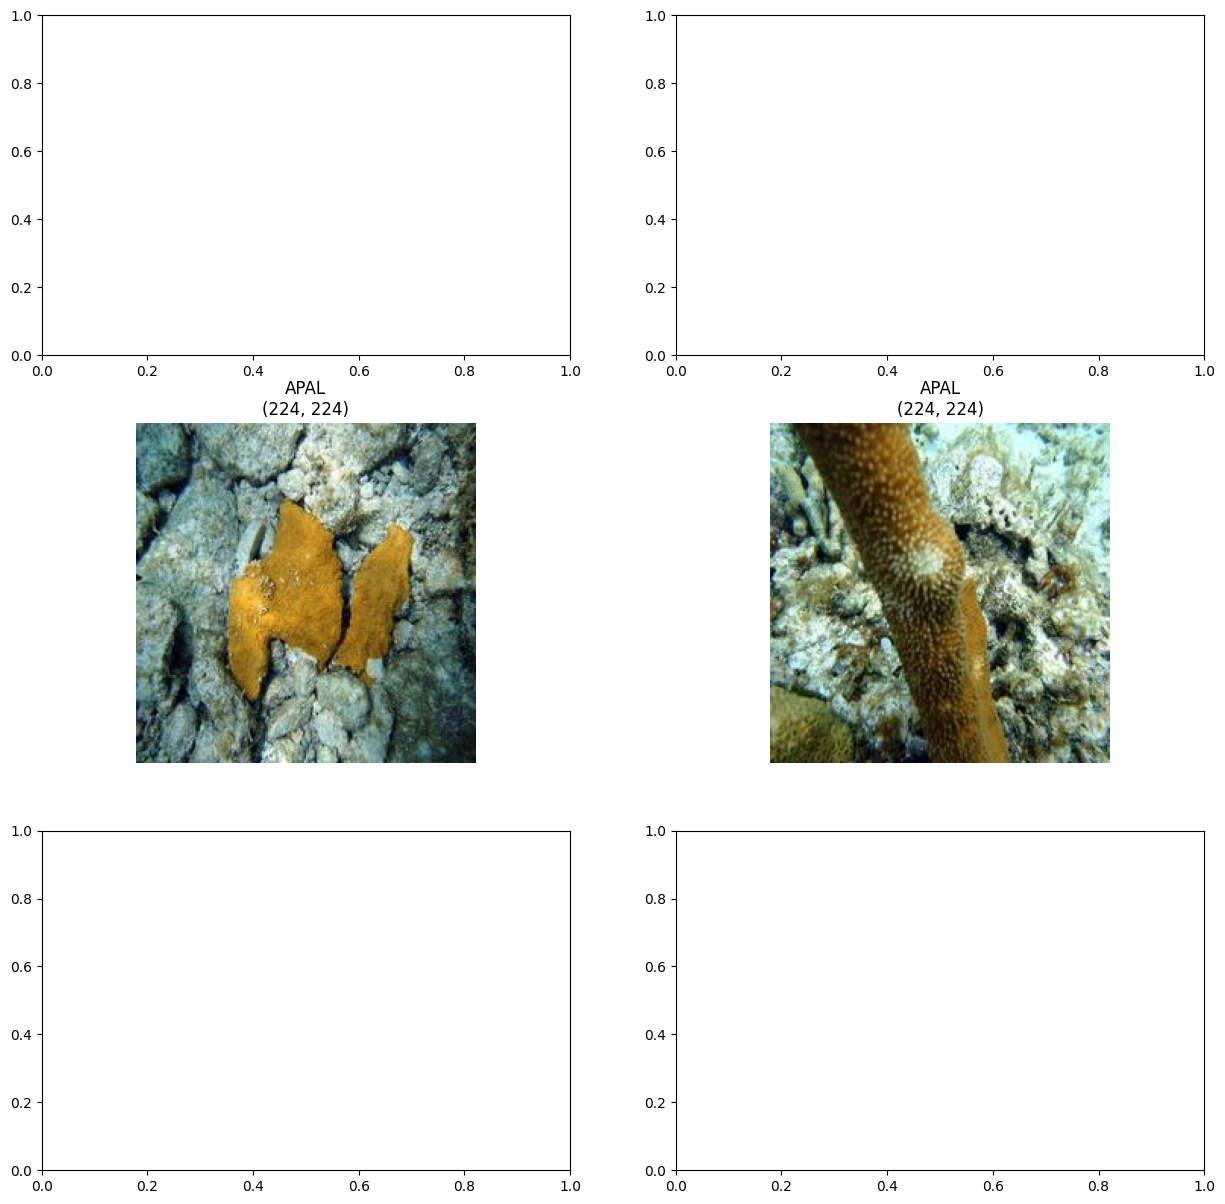

In [13]:
import os
import matplotlib.pyplot as plt
import random

# Define the number of images to visualize for each class
num_images_per_class = 2

# Create a list of class names
class_names = train_dataset.class_names

# Initialize a subplot for visualizing the images
fig, axes = plt.subplots(len(class_names), num_images_per_class, figsize=(15, 15))

for class_id, class_name in enumerate(class_names):
    # Get a list of image IDs for the current class
    image_ids = [info["id"] for info in train_dataset.image_info if class_name in info["path"]]

    # Ensure that there are enough images to sample from
    if len(image_ids) >= num_images_per_class:
        random_image_ids = random.sample(image_ids, num_images_per_class)
    else:
        random_image_ids = image_ids  # Use all available images

    for i, image_id in enumerate(random_image_ids):
        image = train_dataset.load_image(image_id)
        mask, class_ids = train_dataset.load_mask(image_id)
        mask = mask[:, :, 0]  # Use only the first instance's mask for simplicity

        ax = axes[class_id, i]
        ax.imshow(image)
        ax.set_title(f"{class_name}\n{mask.shape}")
        ax.axis('off')

plt.show()
